# State of the Art + ? Analytical Method

In [1]:
from utils.analytical.utils import *

 while the motor current multiplied by the torque constants provide an estimate of the joint torques, it is noisy. Anther source of torque is from the dual encoder assemby present in the cobot. In the cobot this assembly helps to give an accurate  measurement of position and velocity, with each  absolute encoder present on both sides of the gearbox, the load side encoder is used for position and the motor side for velocity. The Harmoic drive transmission has flexible element which deforms under torsion. this deformation can be calulated from the difference between load encoder and motor encder. the difference should be zero if there is no deformation. The anufactureres dataseet of the harmonic drive transmission provides the deformation to torque relation as a peicewise linear function. other sources has also modeled it as a cubic polynomial. So the joint torqes can hence be obtained from the enocder deformation. However on thing to note is that , this torque doesnt include the motor friction which is also a component of the joint torque. Onorder to estimate the external joint torque , an estimate of the joint torque is necessary. This estimate can be formulated by decomposing the known and torques on the encoder, which include friction, dynamics, and a characteristic footprint, which could be due to the eccentricity of the flexspline in the gearbox, this is a position dependant deformation. After compensating all these effects, it can be observed in the figure that the residual deformation is almost but not entirely zero , in this case where there was no ecternal torque. , in the presence of external torque, this residual deformation can converted to torque using the piecewise linear funciton. hence it is demonstrated that dual enocders  and gearbox torsion provides an additional source for estimating the external torque applied.

Analytical approach of finding the external joint torque focuses on modeling and computing all the known torques acting at the joint such as friction, dynamics, position based torque (footprint).After compensatig for the known torques, the hypothesis is that the residual will be the external torque. Inorder to simplify the study, only Axis 3 was studied , the other joint angles were kept locked at 0°. a

## 3.1.1 Data Colleciton

To simplify the dynamics acting on the joint under study (Axis 3), the robot was mounted in a 90° orientation so that the axis of the joint is paralell to gravity, which allows the axis to be rotated wihtout gravity affetcing the dynamics. #insert figure for reference. 

In [2]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("analytical_dataset")
data = preprocess()

downloading data:   0%|          | 0/170923 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


Processing 0.04:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.72:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.6:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.47:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.22:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.13:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.33:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.71:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.58:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.29:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.5:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.46:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.44:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.87:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.53:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.54:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.03:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.89:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.1:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 1.0:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.63:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.21:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.94:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.4:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.83:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.67:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.12:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.27:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.97:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.56:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.36:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.01:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.98:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.43:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.09:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.15:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.08:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.05:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.16:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.95:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.62:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.14:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.91:   0%|          | 0/3 [00:00<?, ?it/s]

Processing 0.18:   0%|          | 0/3 [00:00<?, ?it/s]

preprocessing:   0%|          | 0/44 [00:00<?, ?it/s]

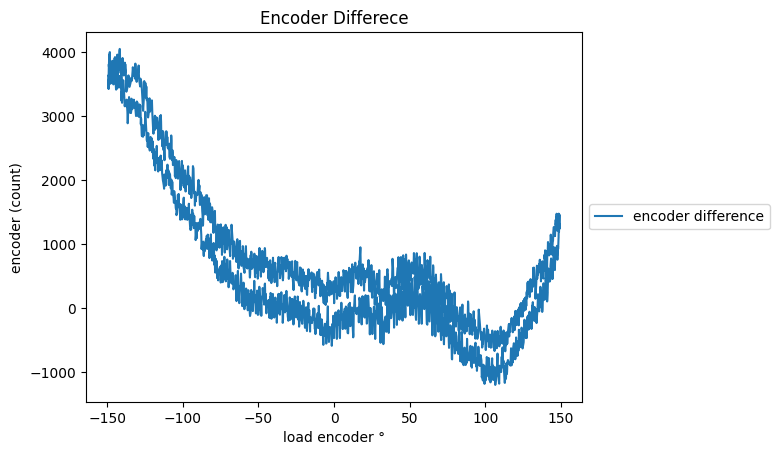

In [3]:
# Select a random sample from the dictionary
import random 

sample = random.choice(list(data.keys()))
plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].encoder_motorinc_3/gear_ratio - data[sample].encoder_loadinc_3,label ='encoder difference')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Encoder Differece")
plt.show()


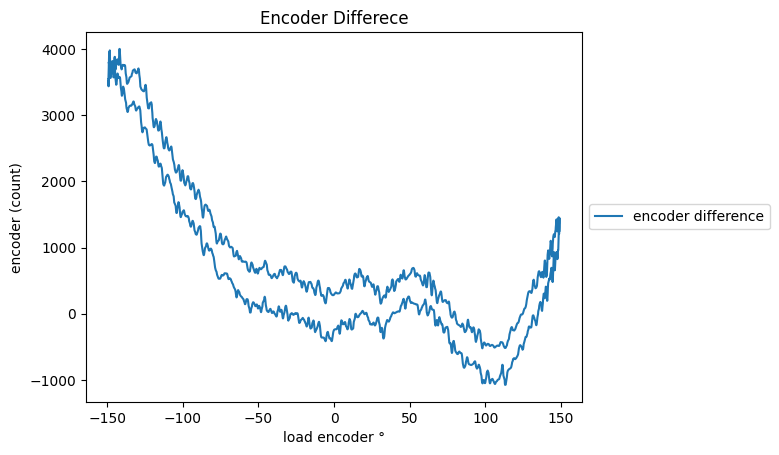

In [4]:
#apply low pass filter
for key in data:
    data[key]= filter(data[key],50)

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].filtered_motor_enc/gear_ratio - data[sample].filtered_load_enc,label ='encoder difference')
plt.ylabel('encoder (count)')
plt.xlabel('load encoder °')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Encoder Differece")
plt.show()

RMS value residual error: 0.007268112126416621
RMS value actual error: 0.03712156801841176
The Model has reduced the error


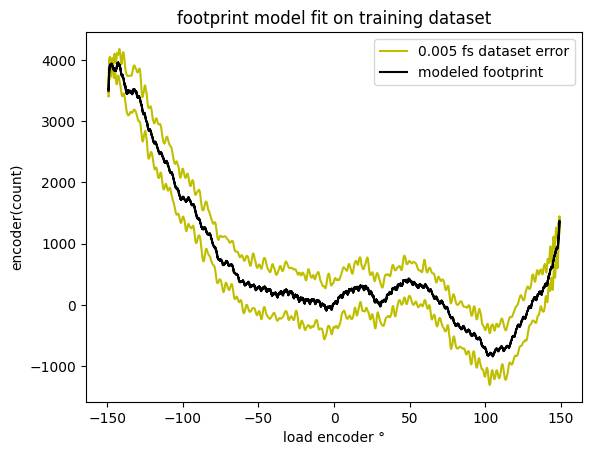

In [5]:
#learn foot print from the slowest data 
footprint_coeff = model_footprint(data["0.97"])
np.save("footprint_coeff.npy",footprint_coeff)

for key in data:
    data[key]['modeled_footprint'] = data[key].apply(lambda row: footprint_error(footprint_coeff,row["filtered_motor_enc"], row["filtered_load_enc"]), axis=1)


plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg, (data["0.97"].filtered_motor_enc/gear_ratio - data["0.97"].filtered_load_enc) ,'y',label = '0.005 fs dataset error')
plt.plot(data["0.97"].encoder_loadinc_3*count_to_deg,data["0.97"].modeled_footprint/count_to_deg,'black',label = 'modeled footprint')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on training dataset")
plt.show()
plt.close()



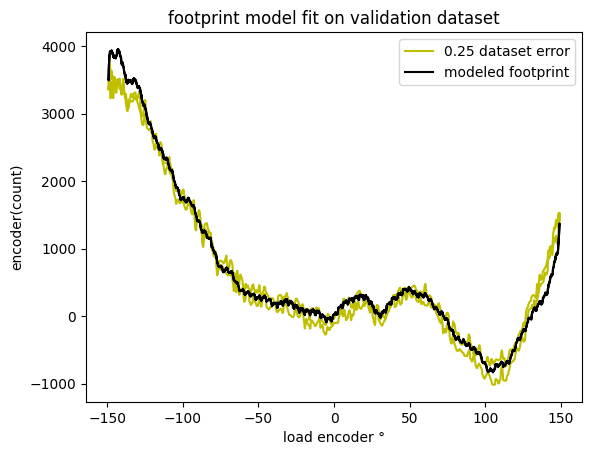

In [6]:
plt.plot(data["0.27"].encoder_loadinc_3*count_to_deg, (data["0.27"].filtered_motor_enc/gear_ratio - data["0.27"].filtered_load_enc) ,'y',label = '0.25 dataset error')
plt.plot(data["0.27"].encoder_loadinc_3*count_to_deg,data["0.27"].modeled_footprint/count_to_deg,'black',label = 'modeled footprint')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("footprint model fit on validation dataset")
plt.show()
plt.close()


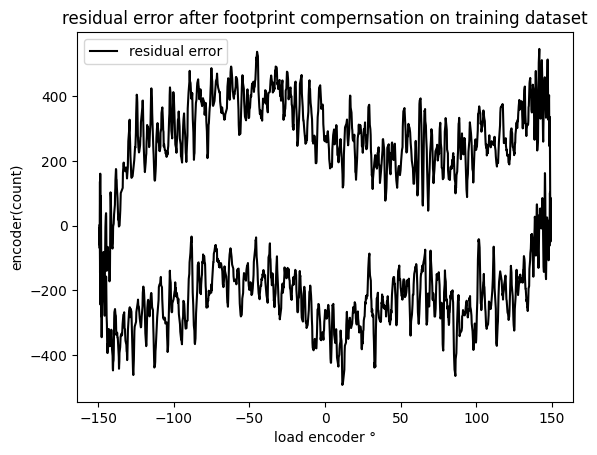

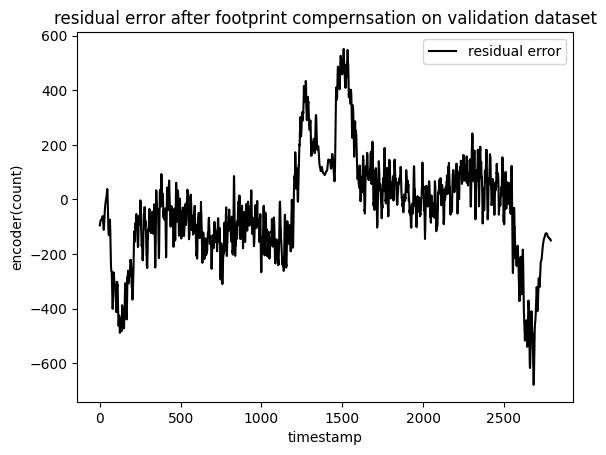

In [8]:
#calculate residuals by compensating for footprint
for key in data:
    data[key]['residual_error'] = data[key].filtered_motor_enc/gear_ratio - data[key].filtered_load_enc - data[key].modeled_footprint/count_to_deg #count

plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].residual_error,'black',label = 'residual error')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("residual error after footprint compernsation on training dataset")
plt.show()
plt.close()

plt.plot(data["0.27"].residual_error,'black',label = 'residual error')
plt.ylabel('encoder(count)')
plt.xlabel('timestamp')
plt.legend()
plt.title("residual error after footprint compernsation on validation dataset")
plt.show()
plt.close()

In [9]:
#compensat for dynamics(remove friction component in dynamic)
for key in data:
    data[key]['inverse_dynamics'] = data[key].apply(lambda row:row["target_joint_torque_3"] - controller_friction_estimate(row["joint_velocity_3"]), axis=1)
    data[key]["dynamic_compensation"] = data[key].apply(lambda row: torque_to_encoder_error(row["inverse_dynamics"]), axis=1)
    data[key]["residual_error2"] = data[key].residual_error - data[key].dynamic_compensation

/usr/local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


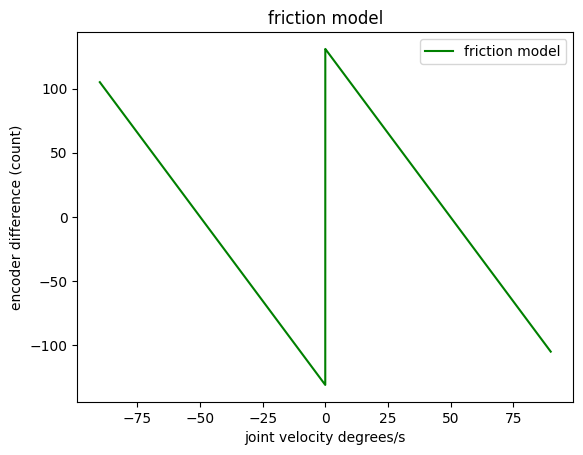

In [10]:
#append all dataframes
dfs = data[sample].iloc[:0,:].copy()
for key in data:
    dfs=pd.concat([dfs,data[key]])

#model friction
parameters,_ = curve_fit(friction_model,dfs.joint_velocity_3*radian_to_deg,dfs.residual_error2)
#save variables to file
np.save("friction_coeff.npy",parameters)

y = np.arange (-90, 90, 0.01)
x = friction_model(y,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5])
plt.plot(y,x,'g',label='friction model')
plt.legend()
plt.xlabel("joint velocity degrees/s")
plt.ylabel("encoder difference (count)")
plt.title("friction model")
plt.legend()
plt.show()
plt.close()


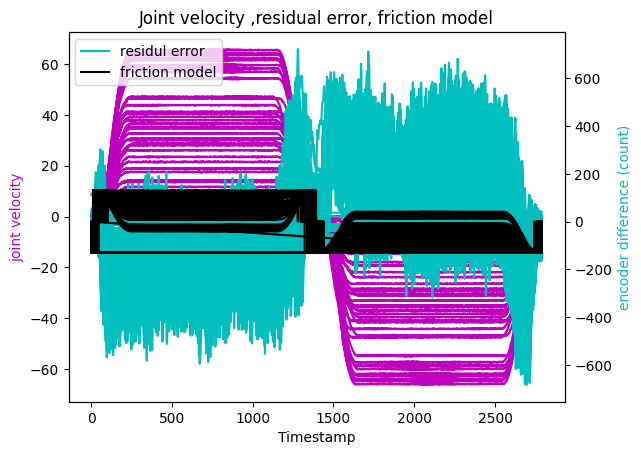

In [11]:


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfs.joint_velocity_3*radian_to_deg,'m',label = " joint velocity")
ax2.plot( dfs.residual_error,'c',label = "residul error")
dfs['modeled_friction'] = dfs.apply(lambda row: friction_model(row["joint_velocity_3"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
ax2.plot(dfs.modeled_friction,'black',label='friction model')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('joint velocity', color='m')
ax2.set_ylabel('encoder difference (count)', color='c')
ax2.legend()
plt.title("Joint velocity ,residual error, friction model")
plt.show()
plt.close()

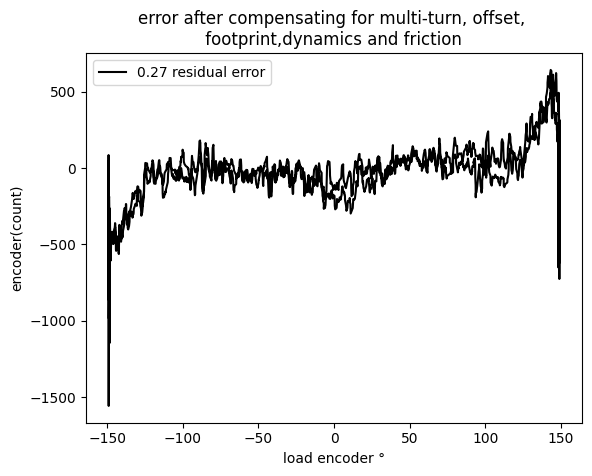

In [12]:
#comepnesate for friction
for key in data:
    data[key]['modeled_friction'] = data[key].apply(lambda row: friction_model(row["filtered_joint_velocity"]*radian_to_deg,parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]), axis=1)
    data[key]["residual_error3"] = data[key].residual_error2 - data[key].modeled_friction
    

plt.plot(data["0.04"].encoder_loadinc_3*count_to_deg, data["0.04"].residual_error3,'black',label = '0.27 residual error')
plt.ylabel('encoder(count)')
plt.xlabel('load encoder °')
plt.legend()
plt.title("error after compensating for multi-turn, offset, \n footprint,dynamics and friction ")
plt.show()
plt.close()


